<a href="https://colab.research.google.com/github/camilotorron/NLP/blob/main/KG_wiki_sentences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy

nlp = spacy.load(r'C:\Users\camil\anaconda3\envs\Entorno\Lib\site-packages\en_core_web_sm\en_core_web_sm-2.3.1')

from spacy.matcher import Matcher
from spacy.tokens import Span

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth',200)
%matplotlib inline

In [ ]:
candidate_sentences = pd.read_csv('https://raw.githubusercontent.com/phgunawan/Latihan-ML/master/wiki_sentences_v2.csv')
candidate_sentences.shape
#candidate_sentences.head()

(4318, 1)

In [ ]:
candidate_sentences['sentence'].sample(10)


2016                                 the plot revolves around thulasi  and krishna .
3149                                      the film was entirely shot in switzerland.
1533                        avm productions is the oldest surviving studio in india.
1734                            some film scripts are first written in latin script.
4304                                                                  arya hugs her.
1815                                       others focus on a religious perspective .
1053                    restoration comedy is notorious for its sexual explicitness.
752     pianists and organists would play either from sheet music, or improvisation.
2918                       hadewijch is a 2009 french film directed by bruno dumont.
415                                        the film was a failure at the box office.
Name: sentence, dtype: object

In [ ]:
doc = nlp("the drawdown process ins governed by astm standard d823")
for tok in doc:
    print(tok.text, "...", tok.dep_)

the ... det
drawdown ... amod
process ... compound
ins ... ROOT
governed ... acl
by ... agent
astm ... compound
standard ... amod
d823 ... pobj


In [ ]:
def get_entities(sent):
      ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

In [ ]:
entity_pairs = []
for i in tqdm(candidate_sentences["sentence"]):
    entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:48<00:00, 89.11it/s] 


In [ ]:
len(entity_pairs)

4318

In [ ]:
def get_relation(sent):
    
  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [ ]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:46<00:00, 93.10it/s] 


In [ ]:
pd.Series(relations).value_counts()[:20]

is             372
was            302
released on     88
are             74
include         72
were            67
released        42
's              39
composed by     35
have            31
became          31
has             30
become          28
released in     27
included        25
called          21
had             21
considered      20
made            20
produced        19
dtype: int64

# Build the knowledge Graph


In [ ]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge': relations})

In [ ]:
G = nx.from_pandas_edgelist(kg_df,"source", "target", edge_attr=True, create_using= nx.MultiDiGraph)

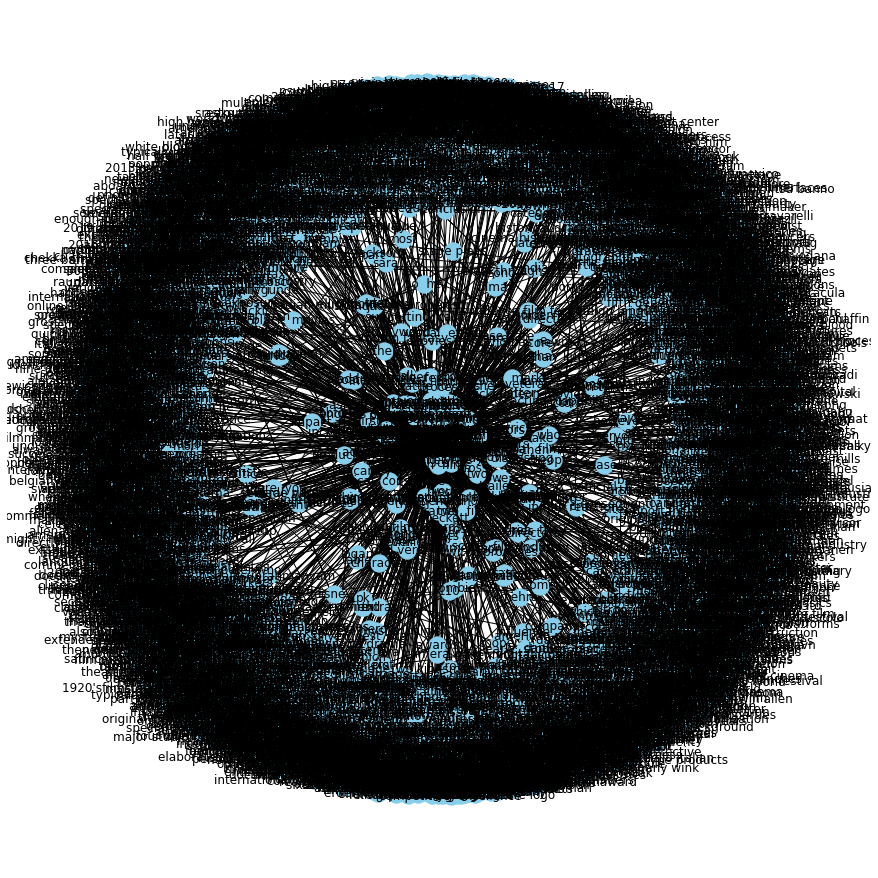

In [ ]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

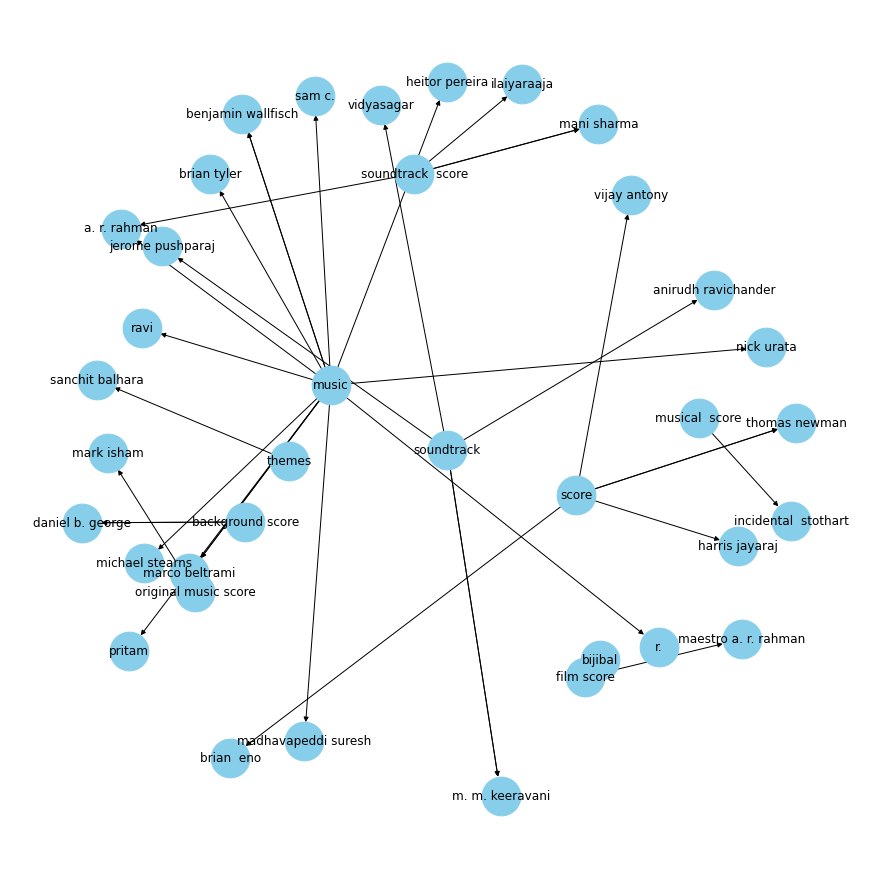

In [ ]:
G = nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"],"source", "target", edge_attr=True,create_using=nx.MultiDiGraph)
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

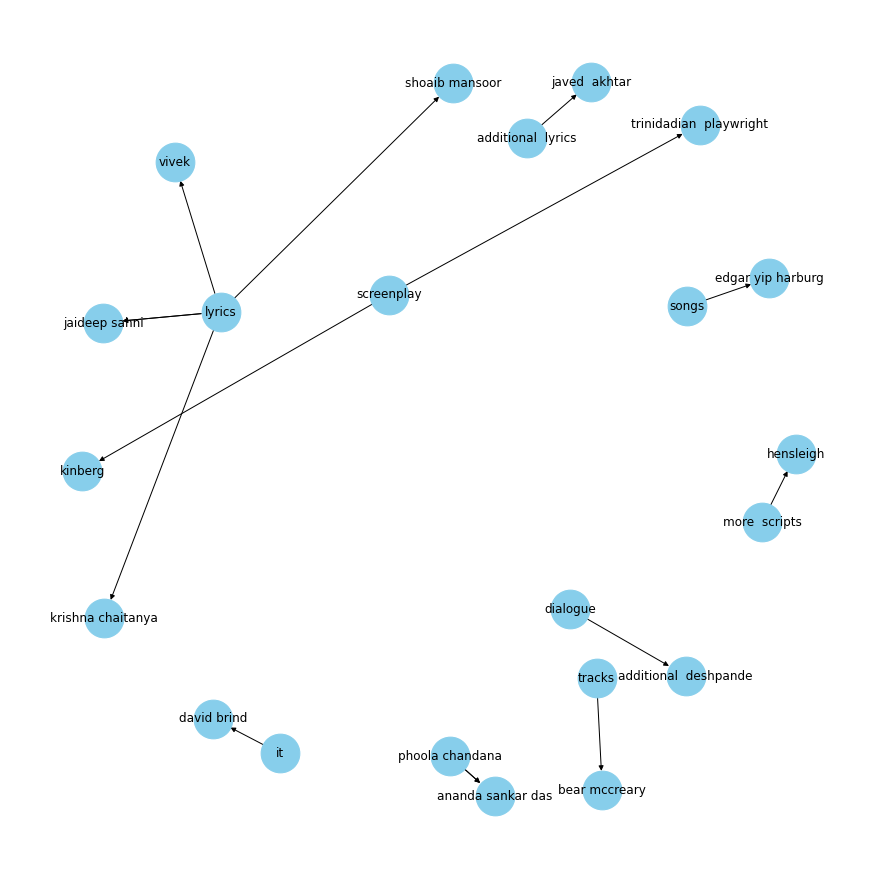

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

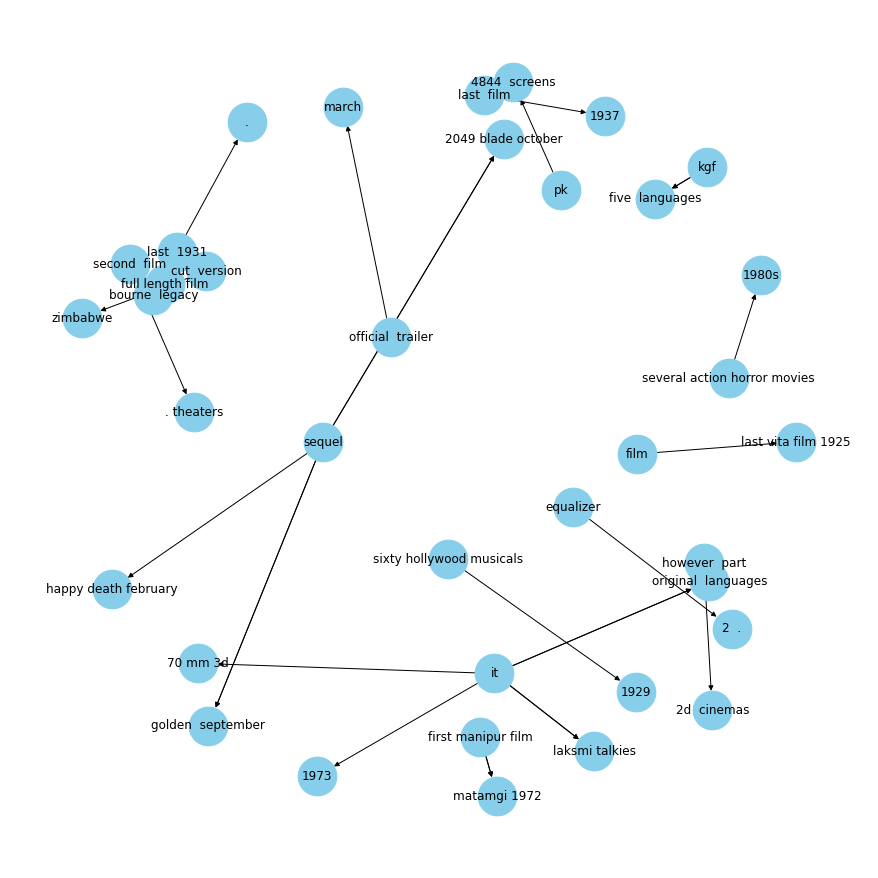

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()